In [1]:
import sys
import os

# Add the folder to the Python path
folder_path = os.path.abspath('C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Code/')
if folder_path not in sys.path:
    sys.path.append(folder_path)

In [597]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})

from ring_functions import *
from odes import *

In [527]:
def combined_ode(t, vars, tau, W_asym, transfer_function, v_in, c_ff, N, x_invman, sigma_W, lambda_W):
    x = vars[:N]  # Extract x (first N elements)
    W_sym = vars[N:].reshape((N, N))  # Extract W (remaining elements)
    
    # Check shapes for debugging
    assert len(vars) == N + N**2, f"Expected length {N + N**2}, but got {len(vars)}"
    assert W_sym.shape == (N, N), f"Expected W_sym shape {(N, N)}, but got {W_sym.shape}"
    
    # Dynamics for x (original ODE)
    dxdt_novel = (-x + np.dot(W_sym, transfer_function(x)) / N + c_ff) / tau
    dxdt = (-x + np.dot(W_sym + v_in(t) * W_asym, transfer_function(x)) / N + c_ff) / tau
    
    # Dynamics for W (now W_ij = x_i * x_j)
    dWdt = -lambda_W * np.outer(dxdt_novel, x)  # Outer product gives the dynamics \dot W_ij = \dot x_i * x_j
    #introduce damping?

    # dWdt = np.zeros((N, N))
    # n_x_invman = len(x_invman)
    # for x_inv_i in x_invman:
    #     dxdt_i = (-x + np.dot(W_sym + v_in(t) * W_asym, transfer_function(x_inv_i)) / N + c_ff) / tau
    #     dWdt += -np.outer(dxdt_i, x_inv_i)/n_x_invman

    eta_t = np.random.multivariate_normal(mean=np.zeros(N**2), cov=sigma_W).reshape((N, N))
    dWdt += eta_t
    
    # Perturbed weight matrix
    
    # Flatten dWdt and append it to dxdt
    return np.concatenate([dxdt, dWdt.flatten()])

def simulate_coupled_xW(y0s, W_sym0, b, W_asym, transfer_function=ReLU, v_in=v_zero, x_invman=[], sigma_W=0, lambda_W=1,
                         tau=1, maxT=25, tsteps=501):
    N = W_sym0.shape[0]
    t = np.linspace(0, maxT, tsteps)
    sols_combined = np.zeros((y0s.shape[1], t.shape[0], N + N**2))

    for yi, y0 in enumerate(y0s.T):
        initial_conditions = np.concatenate([y0, W_sym0.flatten()])
        
        # Check the length of initial_conditions
        assert len(initial_conditions) == N + N**2, f"Expected length {N + N**2}, but got {len(initial_conditions)}"
        
        # Solve the combined system of ODEs (x and W)
        sol = solve_ivp(combined_ode, y0=initial_conditions, t_span=[0, maxT],
                        args=(tau, W_asym, transfer_function, v_in, b, N, x_invman, sigma_W, lambda_W),
                        dense_output=True)
        
        # Extract the solutions for x from the output
        sols_combined[yi, ...] = sol.sol(t)[:, :].T

    return sols_combined


def convert_to_angle(a_act, inits, pca):
    #a_act = sols[:,:,:N]
    act_proj2 = pca.transform(a_act.reshape(-1, N))
    act_proj2 = act_proj2.reshape(a_act.shape[0], a_act.shape[1], 2)
    inits_proj2 = pca.transform(inits)
    decoded_angle = np.arctan2(act_proj2[:,:,1], act_proj2[:,:,0]) - np.arctan2(inits_proj2[:,1][:, np.newaxis], inits_proj2[:,0][:, np.newaxis])
    decoded_angle = np.unwrap(decoded_angle)
    return decoded_angle

noplast_color = "#e69f00"  # Light Amber 
noplast_av_color = "#a45f00"  # Darker shade of Amber

plast_color = "#1e90ff"  # Dodger Blue
plast_av_color = "#1257a5"  # Darker shade of Dodger Blue

int_vt_color = "#000000"  # Black


In [541]:
np.random.seed(1331)

tau = 1
transfer_function = ReLU
N = 6
J_I = -2.4
J_E = 4
W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
W_asym = get_noorman_asymmetric_weights(N)
c_ff = 1.
v_in=v_zero
vel_constant = -0.5
t_switch = 0
v_in=v_constant(value=vel_constant)
v_in=v_switch(values=[vel_constant,0], t_switch=t_switch)

maxT = 50
tsteps = 501
t = np.linspace(0, maxT, tsteps)
y0 = np.random.uniform(0,1,N)

sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, v_in]),dense_output=True)

m = np.max(sol.sol(t)) # m #round? what should the maximum be according to the paper?
corners = get_corners(N, m)
bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=.2)
all_bumps = get_all_bumps(N, bumps)

epsilon = .0
W_p = np.random.normal(0,epsilon,(N,N))


#########zero velocity input plasticity effect experiment
#no plasticity
scalar_sigma_W = 0.01
sigma_W = scalar_sigma_W*np.eye(N**2)
lambda_W = 0
np.random.seed(1331)
sols_combined_noplast = simulate_coupled_xW(y0s=all_bumps[:].T, W_sym0=W_sym+W_p, b=c_ff, W_asym=W_asym, sigma_W=sigma_W, lambda_W=lambda_W,
                                    transfer_function=transfer_function, v_in=v_in,
                                     x_invman=all_bumps, tau=tau, maxT=maxT, tsteps=tsteps)

#plasticity
lambda_W = 1
np.random.seed(1331)
sols_combined_plast = simulate_coupled_xW(y0s=all_bumps[:].T, W_sym0=W_sym+W_p, b=c_ff, W_asym=W_asym, sigma_W=sigma_W, lambda_W=lambda_W,
                                    transfer_function=transfer_function, v_in=v_in,
                                     x_invman=all_bumps, tau=tau, maxT=maxT, tsteps=tsteps)

#no noise
# sigma_W = 0.0*np.eye(N**2)
# lambda_W = 1
# sols_combined_nonoise = simulate_coupled_xW(y0s=corners[:].T, W_sym0=W_sym+W_p, b=c_ff, W_asym=W_asym, sigma_W=sigma_W, lambda_W=lambda_W,
#                                     transfer_function=transfer_function, v_in=v_in,
#                                      x_invman=all_bumps, tau=tau, maxT=maxT, tsteps=tsteps)

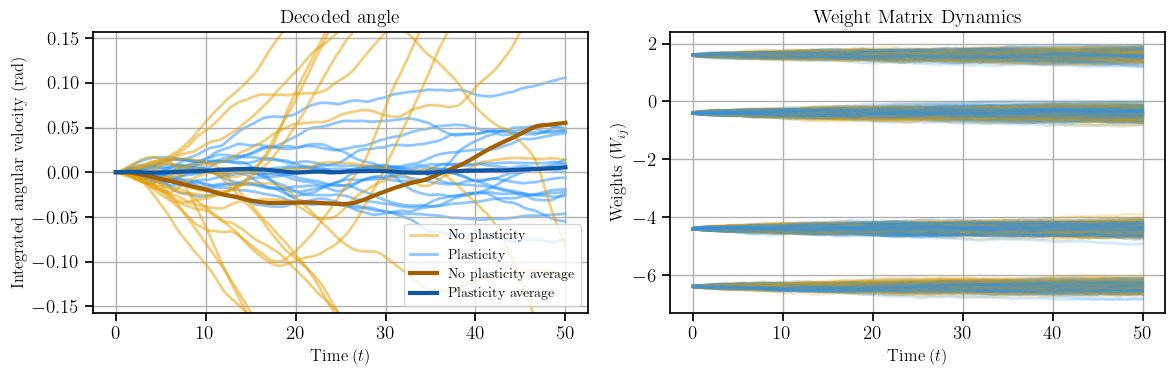

In [543]:
#########constant velocity input plasticity effect experiment

vel_constant = -0.5
v_in=v_constant(value=vel_constant)
#no plasticity
lambda_W = 0
np.random.seed(1331)
sols_combined_noplast = simulate_coupled_xW(y0s=all_bumps[:].T, W_sym0=W_sym+W_p, b=c_ff, W_asym=W_asym, sigma_W=sigma_W, lambda_W=lambda_W,
                                    transfer_function=transfer_function, v_in=v_in,
                                     x_invman=all_bumps, tau=tau, maxT=maxT, tsteps=tsteps)

#plasticity
lambda_W = 1
np.random.seed(1331)
sols_combined_plast = simulate_coupled_xW(y0s=all_bumps[:].T, W_sym0=W_sym+W_p, b=c_ff, W_asym=W_asym, sigma_W=sigma_W, lambda_W=lambda_W,
                                    transfer_function=transfer_function, v_in=v_in,
                                     x_invman=all_bumps, tau=tau, maxT=maxT, tsteps=tsteps)


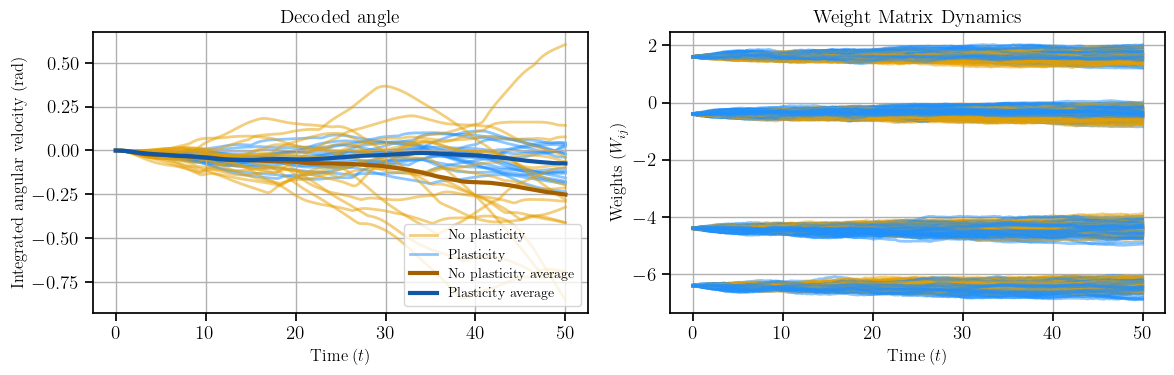

In [544]:
Wt_noplast = sols_combined_noplast[:,:,N:]
Wt_plast = sols_combined_plast[:,:,N:]
int_vt = -t * vel_constant / 4
decoded_angle_noplast = convert_to_angle(sols_combined_noplast[:,:,:N], all_bumps, pca) - int_vt
decoded_angle_plast = convert_to_angle(sols_combined_plast[:,:,:N], all_bumps, pca) - int_vt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True, width_ratios=[3, 1])

# Plot the decoded angles over time
for i in range(decoded_angle_noplast.shape[0]):
    ax1.plot(t, decoded_angle_noplast[i], color=noplast_color, alpha=0.5, label='No plasticity', linewidth=2)
    ax1.plot(t, decoded_angle_plast[i], color=plast_color, alpha=0.5, label='Plasticity', linewidth=2, zorder=0)

ax1.plot(t, np.mean(decoded_angle_noplast, axis=0), color=noplast_av_color, label='No plasticity average', linewidth=3)
ax1.plot(t, np.mean(decoded_angle_plast, axis=0), color=plast_av_color, label='Plasticity average', linewidth=3)

ax1.set_title('Decoded angle', fontsize=14)
ax1.set_xlabel(r'Time ($t$)', fontsize=12)
ax1.set_ylabel(r'Integrated angular velocity (rad)', fontsize=12)
ax1.grid(True)

# Create the kernel density plot for the final decoded angles
final_decoded_angle_noplast = decoded_angle_noplast[:,-1]  # Get the final decoded angles for No Plasticity
final_decoded_angle_plast = decoded_angle_plast[:,-1]  # Get the final decoded angles for Plasticity

bin_min = min(final_decoded_angle_plast.min(), final_decoded_angle_noplast.min())  
bin_max = max(final_decoded_angle_plast.max(), final_decoded_angle_noplast.max())  
bins = np.linspace(bin_min, bin_max, 31)  # 30 equal-width bins

# Compute histogram values manually for proper normalization
final_decoded_angle_noplast_counts, bin_edges = np.histogram(final_decoded_angle_noplast, bins=bins)
final_decoded_angle_plast_counts, _ = np.histogram(final_decoded_angle_plast, bins=bins)

# Convert counts to probability density
bin_width = bins[1] - bins[0]  # Ensure equal bin widths
final_decoded_angle_noplast_pdf = final_decoded_angle_noplast_counts / final_decoded_angle_noplast_counts.sum()
final_decoded_angle_plast_pdf = final_decoded_angle_plast_counts / final_decoded_angle_plast_counts.sum()

sns.kdeplot(final_decoded_angle_noplast, ax=ax2, color=noplast_color, label='No plasticity', fill=True, linewidth=2, vertical=True)
sns.kdeplot(final_decoded_angle_plast, ax=ax2, color=plast_color, label='Plasticity', fill=True, linewidth=2, vertical=True)

ax2.set_title('Final angles', fontsize=14)
ax2.set_xlabel(r'Density', fontsize=12)
ax2.set_ylabel(r'Final Decoded Angle (rad)', fontsize=12)
ax2.grid(True)
ax2.set_xticks([])

# Legend handling
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=10)

handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(f'C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plast_vs_noplast_decangle_dens_constantvel_sigmaW{scalar_sigma_W}.png', bbox_inches='tight', dpi=500)
plt.savefig(f'C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plast_vs_noplast_decangle_dens_constantvel_sigmaW{scalar_sigma_W}.pdf', bbox_inches='tight', dpi=500)
plt.show()

C:\Users\abel_\AppData\Local\Temp\ipykernel_30488\1942155501.py:47: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(final_decoded_angle_noplast, ax=ax2, color=noplast_color, label='No plasticity', fill=True, linewidth=2, vertical=True)
C:\Users\abel_\AppData\Local\Temp\ipykernel_30488\1942155501.py:48: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(final_decoded_angle_plast, ax=ax2, color=plast_color, label='Plasticity', fill=True, linewidth=2, vertical=True)


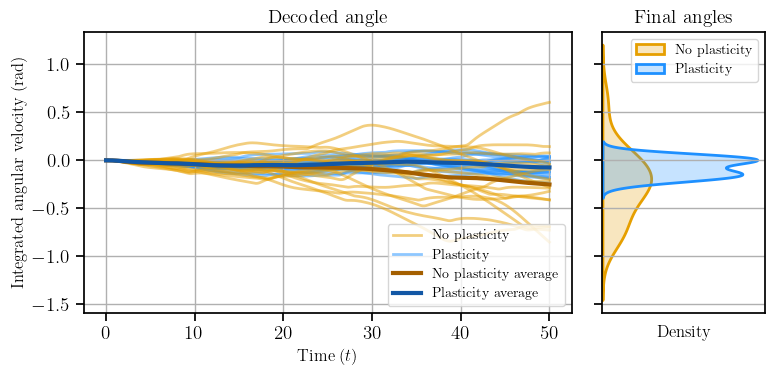

In [596]:


Wt_noplast = sols_combined_noplast[:,:,N:]
Wt_plast = sols_combined_plast[:,:,N:]
int_vt = -t * vel_constant / 4
decoded_angle_noplast = convert_to_angle(sols_combined_noplast[:,:,:N], all_bumps, pca) - int_vt
decoded_angle_plast = convert_to_angle(sols_combined_plast[:,:,:N], all_bumps, pca) - int_vt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True, width_ratios=[3, 1])

# Plot the decoded angles over time
for i in range(decoded_angle_noplast.shape[0]):
    ax1.plot(t, decoded_angle_noplast[i], color=noplast_color, alpha=0.5, label='No plasticity', linewidth=2)
    ax1.plot(t, decoded_angle_plast[i], color=plast_color, alpha=0.5, label='Plasticity', linewidth=2, zorder=0)

ax1.plot(t, np.mean(decoded_angle_noplast, axis=0), color=noplast_av_color, label='No plasticity average', linewidth=3)
ax1.plot(t, np.mean(decoded_angle_plast, axis=0), color=plast_av_color, label='Plasticity average', linewidth=3)

ax1.set_title('Decoded angle', fontsize=14)
ax1.set_xlabel(r'Time ($t$)', fontsize=12)
ax1.set_ylabel(r'Integrated angular velocity (rad)', fontsize=12)
ax1.grid(True)

# Create the kernel density plot for the final decoded angles
final_decoded_angle_noplast = decoded_angle_noplast[:,-1]  # Get the final decoded angles for No Plasticity
final_decoded_angle_plast = decoded_angle_plast[:,-1]  # Get the final decoded angles for Plasticity

bin_min = min(final_decoded_angle_plast.min(), final_decoded_angle_noplast.min())  
bin_max = max(final_decoded_angle_plast.max(), final_decoded_angle_noplast.max())  
bins = np.linspace(bin_min, bin_max, 31)  # 30 equal-width bins

# Compute histogram values manually for proper normalization
final_decoded_angle_noplast_counts, bin_edges = np.histogram(final_decoded_angle_noplast, bins=bins)
final_decoded_angle_plast_counts, _ = np.histogram(final_decoded_angle_plast, bins=bins)

# Convert counts to probability density
bin_width = bins[1] - bins[0]  # Ensure equal bin widths
final_decoded_angle_noplast_pdf = final_decoded_angle_noplast_counts / final_decoded_angle_noplast_counts.sum()
final_decoded_angle_plast_pdf = final_decoded_angle_plast_counts / final_decoded_angle_plast_counts.sum()

# Plot the horizontal bars for the No plasticity data
#ax2.barh(bins[:-1], final_decoded_angle_noplast_pdf, height=bin_width, alpha=0.7, color=noplast_color, label='No plasticity')
#ax2.barh(bins[:-1], final_decoded_angle_plast_pdf, height=bin_width, alpha=0.7, color=plast_color, label='Plasticity')

sns.kdeplot(final_decoded_angle_noplast, ax=ax2, color=noplast_color, label='No plasticity', fill=True, linewidth=2, vertical=True)
sns.kdeplot(final_decoded_angle_plast, ax=ax2, color=plast_color, label='Plasticity', fill=True, linewidth=2, vertical=True)

ax2.set_title('Final angles', fontsize=14)
ax2.set_xlabel(r'Density', fontsize=12)
ax2.set_ylabel(r'Final Decoded Angle (rad)', fontsize=12)
ax2.grid(True)
ax2.set_xticks([])

# Legend handling
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=10)

handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(f'C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plast_vs_noplast_decangle_dens_constantvel_sigmaW{scalar_sigma_W}.png', bbox_inches='tight', dpi=500)
plt.savefig(f'C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plast_vs_noplast_decangle_dens_constantvel_sigmaW{scalar_sigma_W}.pdf', bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
# #############PLot with weight dyns
# Wt_noplast = sols_combined_noplast[:,:,N:]
# Wt_plast = sols_combined_plast[:,:,N:]
# decoded_angle_noplast = convert_to_angle(sols_combined_noplast[:,:,:N], all_bumps, pca)
# decoded_angle_plast = convert_to_angle(sols_combined_plast[:,:,:N], all_bumps, pca)
# #decoded_angle_nonoise = convert_to_angle(sols_combined_nonoise[:,:,:N], corners, pca)
# int_vt = -t*vel_constant/4
# int_vt[t_switch*10:] = int_vt[t_switch*10]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# for i in range(decoded_angle_noplast.shape[0]):
#     ax1.plot(t, decoded_angle_noplast[i], color=noplast_color, alpha=0.5, label='No plasticity', linewidth=2)
#     ax1.plot(t, decoded_angle_plast[i], color=plast_color, alpha=0.5, label='Plasticity', linewidth=2, zorder=0)
# ax1.plot(t, np.mean(decoded_angle_noplast, axis=0), color=noplast_av_color, label='No plasticity average', linewidth=3)
# ax1.plot(t, np.mean(decoded_angle_plast, axis=0), color=plast_av_color, label='Plasticity average', linewidth=3)


# #ax1.plot(t, int_vt, color=int_vt_color, label='Angle', linewidth=2)
# ax1.set_title('Decoded angle', fontsize=14)
# ax1.set_xlabel(r'Time ($t$)', fontsize=12)
# ax1.set_ylabel(r'Integrated angular velocity (rad)', fontsize=12)
# ax1.grid(True)
# ax1.set_ylim(-np.pi/20, np.pi/20)
# handles, labels = ax1.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax1.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=10)

# # Plot weight matrix 
# for i in range(decoded_angle_noplast.shape[0]):
#     ax2.plot(t, Wt_noplast[i], color=noplast_color, alpha=0.2, label='No plasticity', linewidth=2)
#     ax2.plot(t, Wt_plast[i], color=plast_color, alpha=0.2, label='No plasticity average', linewidth=2)
# #ax2.plot(t, np.mean(Wt_noplast,axis=0), color=noplast_av_color, label='Plasticity', linewidth=2)
# ax2.set_title('Weight Matrix Dynamics', fontsize=14)
# ax2.set_xlabel(r'Time ($t$)', fontsize=12)
# ax2.set_ylabel(r'Weights ($W_{ij}$)', fontsize=12)
# ax2.grid(True)

# plt.tight_layout()
# plt.savefig(f'C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plast_vs_noplast_decangle_sigmaW{scalar_sigma_W}.png', bbox_inches='tight', dpi=500)
# plt.savefig(f'C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plast_vs_noplast_decangle_sigmaW{scalar_sigma_W}.pdf', bbox_inches='tight', dpi=500)
# plt.show()

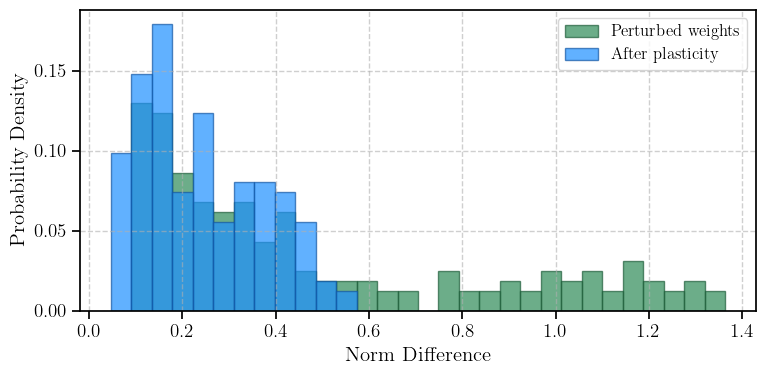

In [236]:
# Compute the differences before and after
before_diff = np.linalg.norm(xt_before[:, 0, :] - xt_before[:, -1, :], axis=1)
after_diff = np.linalg.norm(xt_after[:, 0, :] - xt_after[:, -1, :], axis=1)

# Define common bin edges
bin_min = min(before_diff.min(), after_diff.min())  
bin_max = max(before_diff.max(), after_diff.max())  
bins = np.linspace(bin_min, bin_max, 31)  # 30 equal-width bins

# Compute histogram values manually for proper normalization
before_counts, _ = np.histogram(before_diff, bins=bins)
after_counts, _ = np.histogram(after_diff, bins=bins)

# Convert counts to probability density
bin_width = bins[1] - bins[0]  # Ensure equal bin widths
before_pdf = before_counts / (before_counts.sum() )
after_pdf = after_counts / (after_counts.sum() )

# Define color palette
before_color = "#2e8b57"  # Sea Green
before_edge = "#1e5d3a"  # Darker shade of Sea Green

after_color = "#1e90ff"  # Dodger Blue
after_edge = "#1257a5"  # Darker shade of Dodger Blue

# Plot histograms with correctly normalized probability densities
plt.figure(figsize=(8, 4))
plt.bar(bins[:-1], before_pdf, width=bin_width, alpha=0.7, label='Perturbed weights', 
        color=before_color, edgecolor=before_edge, align='edge')
plt.bar(bins[:-1], after_pdf, width=bin_width, alpha=0.7, label='After plasticity', 
        color=after_color, edgecolor=after_edge, align='edge')

# Labels and formatting
plt.xlabel('Norm Difference', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
#plt.title('Probability Distribution of Activation Differences', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()

plt.savefig('C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plasticity_effect_hist.pdf', bbox_inches='tight', dpi=500)

plt.show()




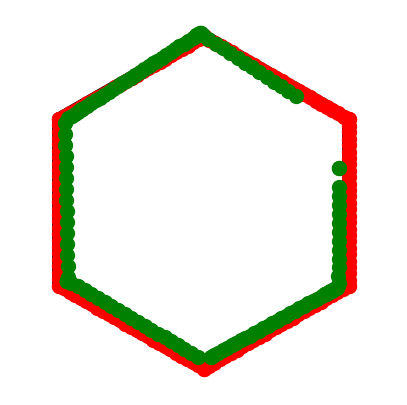

In [226]:
N_points = bumps.shape[0]*bumps.shape[1]
pca = sklearn.decomposition.PCA(n_components=2)
X_proj2 = pca.fit_transform(xt_before[:,0,:]) 
all_bumps_proj2 = pca.fit_transform(all_bumps) 
corners_proj2 = pca.transform(corners)
xt_before_proj2 = pca.transform(xt_before[:,-1,:])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'k', label="Original attractor", zorder=0, alpha=1., linewidth=10, 
            solid_capstyle='round')
    
ax.plot(X_proj2[:,0], X_proj2[:,1], '.r', label="Stable", zorder=10, alpha=1., markersize=20)
ax.plot(xt_before_proj2[:,0], xt_before_proj2[:,1], '.g', zorder=10, alpha=1., markersize=20)


lims = 3.
ax.set(xlim=(-lims, lims), ylim=(-lims,lims))

ax.set_axis_off()
# plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}.pdf", bbox_inches="tight")